In [45]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [46]:
overdamped_path = "/home/dda24/PTL-PINNs/ptlpinns/models/train/overdamped_k14"
overdamped_name = "model_overdamped_k14.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

14 True False False [128, 128, 256]


### Problem definition

In [47]:
N = 5120
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [48]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [49]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 40, 60]

#forcing_freq = [[1]]
#forcing_coef = [[1]]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force


forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.7, 0.7, 0.7, 0.7, 0.7]
p_list = [9]
q = 3

### Numerical solver

In [50]:
numerical_undamped_duffing_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_undamped_duffing_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [51]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [52]:
NN_TL_solution.shape

(5120, 5, 2)

In [53]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.09448520837562216
zeta: 5, order: 1, mean error absolute: 0.03079648317161122
zeta: 5, order: 2, mean error absolute: 0.012123011208839908
zeta: 5, order: 3, mean error absolute: 0.005794437205324258
zeta: 5, order: 4, mean error absolute: 0.0025655061322449055
zeta: 5, order: 5, mean error absolute: 0.0015853021125513441
zeta: 5, order: 6, mean error absolute: 0.0006603360367933655
zeta: 5, order: 7, mean error absolute: 0.0006077005747097758
zeta: 5, order: 8, mean error absolute: 0.00021580067219824969


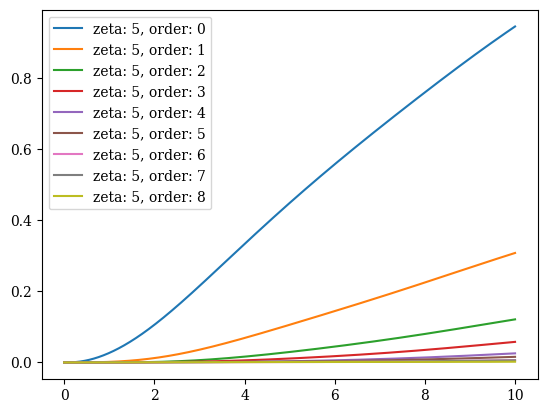

zeta: 10, order: 0, mean error absolute: 0.08047895056546221
zeta: 10, order: 1, mean error absolute: 0.017757585403568005
zeta: 10, order: 2, mean error absolute: 0.0051887658469498095
zeta: 10, order: 3, mean error absolute: 0.0014681520331486972
zeta: 10, order: 4, mean error absolute: 0.0006873052911845674
zeta: 10, order: 5, mean error absolute: 0.00021698348776520504
zeta: 10, order: 6, mean error absolute: 0.00023093563613055075
zeta: 10, order: 7, mean error absolute: 0.00013808247103628505
zeta: 10, order: 8, mean error absolute: 0.00017273742342755182


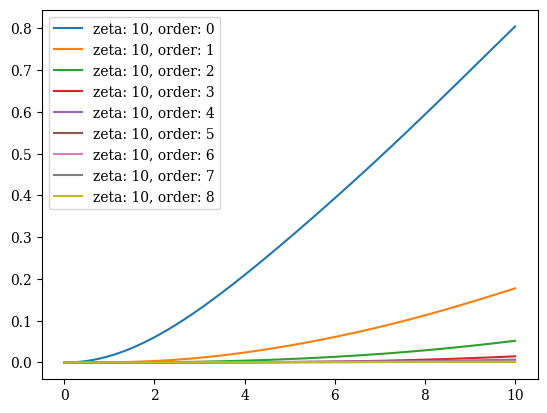

zeta: 30, order: 0, mean error absolute: 0.043153335096497054
zeta: 30, order: 1, mean error absolute: 0.004270823385298756
zeta: 30, order: 2, mean error absolute: 0.0005365837619847264
zeta: 30, order: 3, mean error absolute: 0.000130286330879586
zeta: 30, order: 4, mean error absolute: 9.956084648120916e-05
zeta: 30, order: 5, mean error absolute: 9.936796252795189e-05
zeta: 30, order: 6, mean error absolute: 9.92887256477779e-05
zeta: 30, order: 7, mean error absolute: 9.929706107158085e-05
zeta: 30, order: 8, mean error absolute: 9.929598448724087e-05


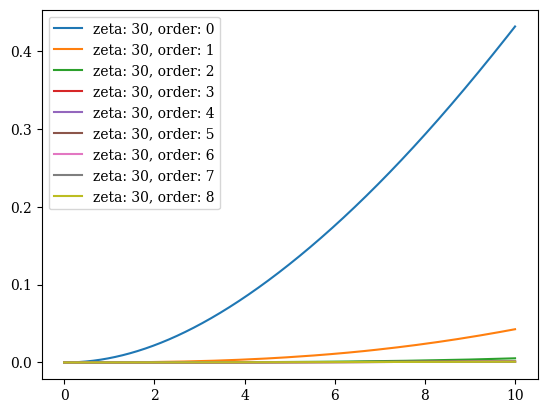

zeta: 40, order: 0, mean error absolute: 0.034678125800033245
zeta: 40, order: 1, mean error absolute: 0.0027586987171351494
zeta: 40, order: 2, mean error absolute: 0.0002342567610366428
zeta: 40, order: 3, mean error absolute: 0.00011343362872133346
zeta: 40, order: 4, mean error absolute: 8.277205655480194e-05
zeta: 40, order: 5, mean error absolute: 8.615093720914743e-05
zeta: 40, order: 6, mean error absolute: 8.572409104916558e-05
zeta: 40, order: 7, mean error absolute: 8.577865516094178e-05
zeta: 40, order: 8, mean error absolute: 8.577144069737902e-05


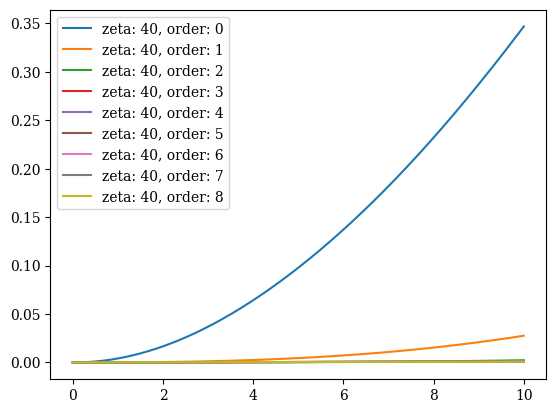

zeta: 60, order: 0, mean error absolute: 0.024938674575645182
zeta: 60, order: 1, mean error absolute: 0.0014499867292586263
zeta: 60, order: 2, mean error absolute: 9.211640500595016e-05
zeta: 60, order: 3, mean error absolute: 0.00011555596823105208
zeta: 60, order: 4, mean error absolute: 0.00010827066453966033
zeta: 60, order: 5, mean error absolute: 0.00010886143761358751
zeta: 60, order: 6, mean error absolute: 0.00010881116709201365
zeta: 60, order: 7, mean error absolute: 0.00010881554002276315
zeta: 60, order: 8, mean error absolute: 0.00010881514744288258


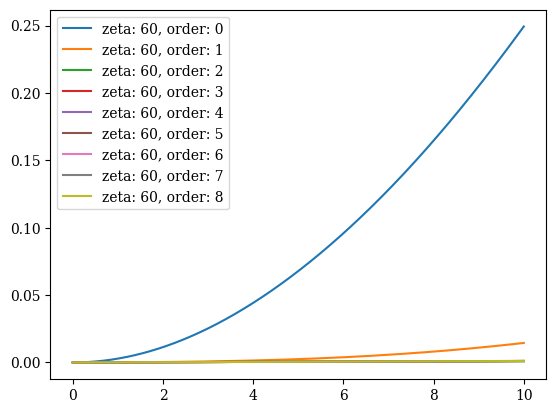

In [54]:
for i in range(len(PINN_solution)):

    for k in range(p_list[0]):

        error = np.abs(numerical_undamped_duffing_list[i][0, :] - PINN_solution[i][k])
        print(f"zeta: {zeta_list[i]}, order: {k}, mean error absolute: {np.mean(error)}")
        cumulative_error = cumulative_trapezoid(error, t_eval, initial=0) 
        plt.plot(t_eval, cumulative_error, label=f"zeta: {zeta_list[i]}, order: {k}")

    plt.legend()
    plt.show()

zeta: 5, mean Error: 3.495e-04
zeta: 10, mean Error: 1.595e-04
zeta: 30, mean Error: 9.930e-05
zeta: 40, mean Error: 8.577e-05
zeta: 60, mean Error: 1.088e-04


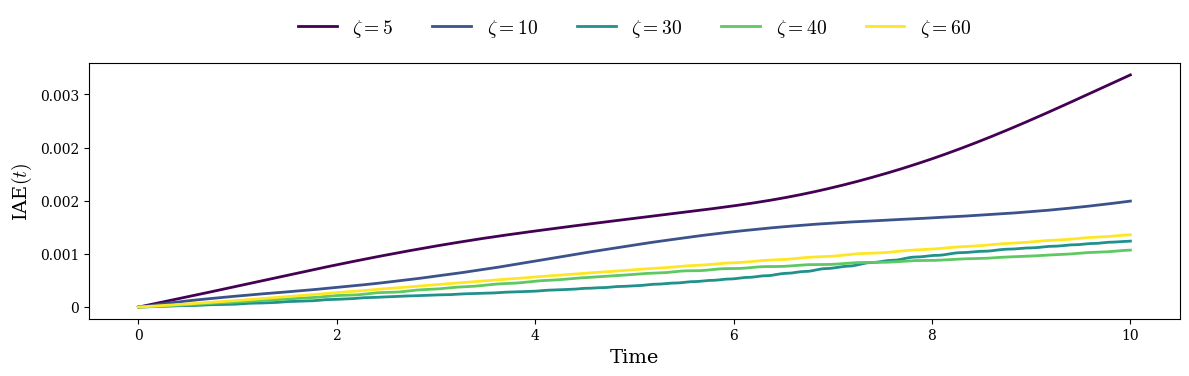

In [55]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_undamped_duffing_list)